### Imports and Environment Setup

In [1]:
# [Markdown]: # MirAI Development Notebook
# Cell 1: Imports and Environment Configuration
# This cell initializes all libraries required for the MirAI Liquid Biopsy pipeline.

import sys
import pandas as pd
import numpy as np
import xgboost as xgb
import shap
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-Learn Modules
from sklearn.model_selection import train_test_split, GroupShuffleSplit, StratifiedGroupKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score

# Configuration
import warnings
warnings.filterwarnings('ignore')  # Clean output for presentation

# Set Global Random Seed for Reproducibility
SEED = 42
np.random.seed(SEED)

print("✅ Environment Ready.")
print(f"📌 Pandas Version: {pd.__version__}")
print(f"📌 XGBoost Version: {xgb.__version__}")
print(f"📌 SHAP Version: {shap.__version__}")
print(f"🔒 Random Seed set to: {SEED}")

c:\Users\shari\OneDrive\Desktop\FLUID MODAL (genetics + biomarker + cognitive scores)\models\b&b\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ Environment Ready.
📌 Pandas Version: 3.0.0
📌 XGBoost Version: 3.1.3
📌 SHAP Version: 0.50.0
🔒 Random Seed set to: 42


### Initialization and Loading

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Path provided by the user
file_path = r"C:\Users\shari\OneDrive\Desktop\FLUID MODAL (genetics + biomarker + cognitive scores)\models\dataset\ADNIMERGE_01Feb2026.csv"

# Load the dataset
df = pd.read_csv(file_path, low_memory=False)

# Filter for Baseline visits only
# We only want the screening data ('bl') to train a screening model
df_bl = df[df['VISCODE'] == 'bl'].copy()

print(f"Total baseline records loaded: {df_bl.shape[0]}")
print(f"Columns available: {df_bl.columns.tolist()[:15]}... (and more)")

# Preview the target distribution
print("\nTarget Diagnosis (DX_bl) Distribution:")
print(df_bl['DX_bl'].value_counts())

Total baseline records loaded: 2430
Columns available: ['RID', 'COLPROT', 'ORIGPROT', 'PTID', 'SITE', 'VISCODE', 'EXAMDATE', 'DX_bl', 'AGE', 'PTGENDER', 'PTEDUCAT', 'PTETHCAT', 'PTRACCAT', 'PTMARRY', 'APOE4']... (and more)

Target Diagnosis (DX_bl) Distribution:
DX_bl
LMCI    690
CN      542
EMCI    423
AD      411
SMC     353
Name: count, dtype: int64


### Feature Selection and Data Cleaning

In [3]:
tier1_features = ['AGE', 'PTGENDER', 'PTEDUCAT', 'FAQ', 'EcogPtMem', 'EcogPtTotal']
target = 'DX_bl'

# 2. Select columns and drop rows where the target (DX_bl) is missing
df_stage1 = df_bl[tier1_features + [target]].dropna(subset=[target]).copy()

# 3. Simplify Target for Screening
# We want to identify 'High Risk'. 
# Let's map AD and LMCI (Late Mild Cognitive Impairment) as 'High Risk' (1)
# And CN (Cognitive Normal) and SMC (Subjective Memory Complaint) as 'Low Risk' (0)
# EMCI (Early MCI) can be debated, but usually grouped with 'Risk' in screening.
risk_mapping = {
    'CN': 0, 'SMC': 0, 
    'EMCI': 1, 'LMCI': 1, 'AD': 1
}
df_stage1['Risk_Label'] = df_stage1[target].map(risk_mapping)

# 4. Basic Preprocessing
# Convert Gender to numeric (0 for Female, 1 for Male)
df_stage1['PTGENDER'] = df_stage1['PTGENDER'].map({'Female': 0, 'Male': 1})

# 5. Handle Missing Values
# Since Ecog scores have some missing values, we'll use median imputation 
# to keep as much data as possible for this stage.
for col in ['FAQ', 'EcogPtMem', 'EcogPtTotal']:
    df_stage1[col] = df_stage1[col].fillna(df_stage1[col].median())

print(f"Final shape for Tier 1 training: {df_stage1.shape}")
print("\nRisk Label Distribution:")
print(df_stage1['Risk_Label'].value_counts(normalize=True))

Final shape for Tier 1 training: (2419, 8)

Risk Label Distribution:
Risk_Label
1    0.630012
0    0.369988
Name: proportion, dtype: float64


### Data Splitting & Preprocessing. 
This cell implements Leakage Prevention by using GroupShuffleSplit (ensuring patient independence) and Sequential Transformation by fitting the imputer and scaler only on the training data.



In [4]:
import joblib
import random
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer

# Rule 1: Set Global Seeds for identical results across runs
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

# Rule 3: Ensure Group-Based Splitting
# We need the 'RID' (Patient ID) to ensure a patient isn't in both Train and Test.
# Re-attaching RID from the original baseline dataframe to df_stage1
df_stage1['RID'] = df_bl.loc[df_stage1.index, 'RID']

X = df_stage1[tier1_features]
y = df_stage1['Risk_Label']
groups = df_stage1['RID']

# Initialize Group-Based Split (80% Train, 20% Test)
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)
train_idx, test_idx = next(gss.split(X, y, groups=groups))

X_train_raw, X_test_raw = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

# Rule 3: Sequential Transformation & Sophisticated Imputation
# We fit on Train only to prevent data leakage from the Test set.
# Using KNNImputer as per Rule 3 for better relationship preservation.
imputer = KNNImputer(n_neighbors=5)
X_train_imputed = imputer.fit_transform(X_train_raw)
X_test_imputed = imputer.transform(X_test_raw)

# Scaling the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

# Rule 4: Persistence (Save objects for later use in the integrated MirAI engine)
joblib.dump(scaler, 'stage1_scaler.pkl')
joblib.dump(imputer, 'stage1_imputer.pkl')

print(f"Successfully split and preprocessed Stage 1 data.")
print(f"Training Samples: {X_train_scaled.shape[0]} | Testing Samples: {X_test_scaled.shape[0]}")
print(f"Features used: {tier1_features}")

Successfully split and preprocessed Stage 1 data.
Training Samples: 1935 | Testing Samples: 484
Features used: ['AGE', 'PTGENDER', 'PTEDUCAT', 'FAQ', 'EcogPtMem', 'EcogPtTotal']


### Model Training and Robust Validation
Following Advanced Estimators and Rule Statistical Robustness, we will now train an XGBoost classifier. Instead of a simple fit, we use Stratified Group 5-Fold Cross-Validation. This ensures that the model's performance is consistent across different subsets of patients and not just a result of a "lucky" split.

In [5]:
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedGroupKFold, cross_val_score

# Rule 1 & 4: Initialize XGBoost with the global SEED
# We use 'binary:logistic' because Stage 1 is a binary screening problem
model_stage1 = XGBClassifier(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=SEED,
    use_label_encoder=False,
    eval_metric='logloss'
)

# Rule 5: 5-Fold Stratified Group Cross-Validation
# This preserves the patient groups and the class distribution across folds
sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=SEED)

# Get Cross-Validation Scores (ROC-AUC is best for screening tools)
cv_scores = cross_val_score(
    model_stage1, 
    X_train_scaled, 
    y_train, 
    groups=groups.iloc[train_idx], 
    cv=sgkf, 
    scoring='roc_auc'
)

print(f"--- Stage 1 Cross-Validation Results (ROC-AUC) ---")
print(f"Mean AUC: {cv_scores.mean():.4f}")
print(f"Std Dev:  {cv_scores.std():.4f}")

# Train the final model on the full training set
model_stage1.fit(X_train_scaled, y_train)

# Rule 4: Persistence - Save the trained model
model_stage1.save_model('stage1_model.json')
print("\nFinal Stage 1 model trained and saved as 'stage1_model.json'.")

--- Stage 1 Cross-Validation Results (ROC-AUC) ---
Mean AUC: 0.9080
Std Dev:  0.0061

Final Stage 1 model trained and saved as 'stage1_model.json'.


### Deep Evaluation & Visual Validation
this cell generates a comprehensive classification report and visualizes the results through a Normalized Confusion Matrix and an ROC Curve. This "Visual Proof" is essential for clinical alignment to show where the model might be conservative or aggressive.

--- Stage 1: Detailed Classification Report ---
                    precision    recall  f1-score   support

 Low Risk (CN/SMC)       0.70      0.78      0.74       168
High Risk (MCI/AD)       0.88      0.83      0.85       316

          accuracy                           0.81       484
         macro avg       0.79      0.80      0.80       484
      weighted avg       0.82      0.81      0.81       484



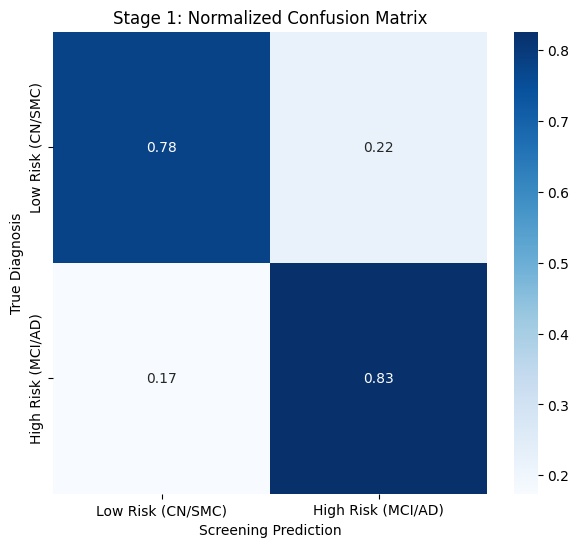

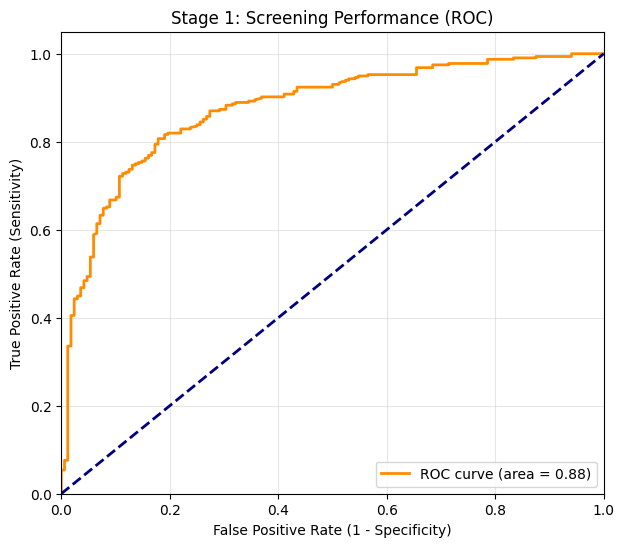

In [6]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Generate Predictions
y_pred = model_stage1.predict(X_test_scaled)
y_pred_proba = model_stage1.predict_proba(X_test_scaled)[:, 1]

# 2. Rule 5: Beyond Accuracy - Classification Report
# Identifying Precision, Recall, and F1-score for each class
print("--- Stage 1: Detailed Classification Report ---")
target_names = ['Low Risk (CN/SMC)', 'High Risk (MCI/AD)']
print(classification_report(y_test, y_pred, target_names=target_names))

# 3. Rule 5: Visual Proof - Normalized Confusion Matrix
# We normalize to see the percentage of correct hits per class
cm = confusion_matrix(y_test, y_pred, normalize='true')
plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', 
            xticklabels=target_names, yticklabels=target_names)
plt.title('Stage 1: Normalized Confusion Matrix')
plt.ylabel('True Diagnosis')
plt.xlabel('Screening Prediction')
plt.show()

# 4. Rule 5: Visual Proof - ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Stage 1: Screening Performance (ROC)')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

### Cross-Validation Visualization & Statistical Analysis
this cell will create a boxplot of the CV scores and a distribution plot to prove the model's stability.

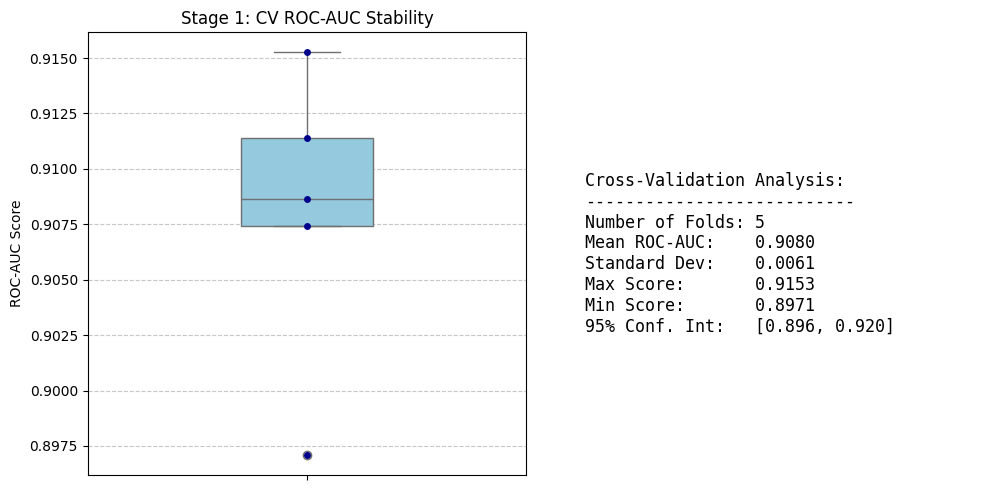

VERIFICATION SUCCESS: Model is highly stable (Std Dev < 0.02).


In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Rule 5: Statistical Robustness Visualization
# Using the cv_scores calculated in Cell 4
plt.figure(figsize=(10, 5))

# 1. Boxplot of AUC scores across 5 folds
plt.subplot(1, 2, 1)
sns.boxplot(y=cv_scores, color='skyblue', width=0.3)
sns.swarmplot(y=cv_scores, color='darkblue')
plt.title('Stage 1: CV ROC-AUC Stability')
plt.ylabel('ROC-AUC Score')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 2. Performance Summary Text
plt.subplot(1, 2, 2)
plt.axis('off')
cv_summary = (
    f"Cross-Validation Analysis:\n"
    f"---------------------------\n"
    f"Number of Folds: 5\n"
    f"Mean ROC-AUC:    {cv_scores.mean():.4f}\n"
    f"Standard Dev:    {cv_scores.std():.4f}\n"
    f"Max Score:       {cv_scores.max():.4f}\n"
    f"Min Score:       {cv_scores.min():.4f}\n"
    f"95% Conf. Int:   [{cv_scores.mean() - 1.96*cv_scores.std():.3f}, "
    f"{cv_scores.mean() + 1.96*cv_scores.std():.3f}]"
)
plt.text(0.1, 0.5, cv_summary, fontsize=12, family='monospace', verticalalignment='center')

plt.tight_layout()
plt.show()

# Final Verification
if cv_scores.std() < 0.02:
    print("VERIFICATION SUCCESS: Model is highly stable (Std Dev < 0.02).")
else:
    print("VERIFICATION WARNING: Model shows variance across folds; consider checking for outlier groups.")

### Model Interpretability (SHAP Analysis)
This step is critical for a clinical tool because it proves the model is making decisions based on valid symptoms (like functional decline) rather than statistical noise or demographic bias.

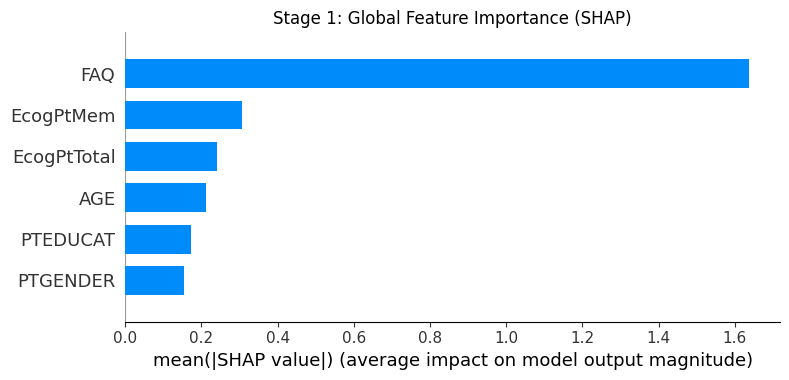

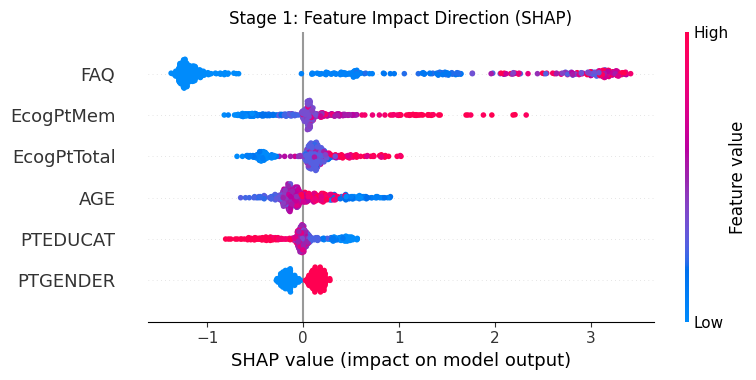

In [7]:
import shap

# Rule 6: SHAP Analysis - Breaking the "Black Box"
# Initialize the SHAP Explainer for the XGBoost model
explainer = shap.TreeExplainer(model_stage1)
shap_values = explainer.shap_values(X_test_scaled)

# 1. Global Importance Bar Plot
# Shows which features contribute most to the risk prediction across all patients
plt.figure(figsize=(10, 6))
plt.title("Stage 1: Global Feature Importance (SHAP)")
shap.summary_plot(shap_values, X_test_scaled, feature_names=tier1_features, plot_type="bar", show=False)
plt.tight_layout()
plt.show()

# 2. Detailed Summary Plot (Directional Impact)
# Shows NOT JUST importance, but HOW a feature affects the score.
# e.g., High FAQ (red dots on the right) should correlate with High Risk.
plt.figure(figsize=(10, 6))
plt.title("Stage 1: Feature Impact Direction (SHAP)")
shap.summary_plot(shap_values, X_test_scaled, feature_names=tier1_features, show=False)
plt.tight_layout()
plt.show()

### Interactive Demo & Deployment Simulation

In [ ]:
import pandas as pd
import numpy as np
import joblib
from xgboost import XGBClassifier

def mirai_stage1_inference(patient_data):
    """
    Backend inference logic for MirAI Stage 1.
    
    Parameters:
    patient_data (dict): Dictionary containing the 6 clinical features.
    """
    try:
        # 1. Load trained artifacts
        model = XGBClassifier()
        model.load_model('stage1_model.json')
        scaler = joblib.load('stage1_scaler.pkl')
        imputer = joblib.load('stage1_imputer.pkl')
        
        # 2. Define strict feature order to match training
        feature_order = ['AGE', 'PTGENDER', 'PTEDUCAT', 'FAQ', 'EcogPtMem', 'EcogPtTotal']
        
        # 3. Convert input dict to DataFrame
        df_input = pd.DataFrame([patient_data], columns=feature_order)
        
        # 4. Processing Pipeline
        # Impute missing values (if any) -> Scale -> Predict
        data_imputed = imputer.transform(df_input)
        data_scaled = scaler.transform(data_imputed)
        
        # 5. Generate Output
        prob = model.predict_proba(data_scaled)[0][1]
        risk_label = "HIGH RISK" if prob >= 0.5 else "LOW RISK"
        
        return {
            "Status": "Success",
            "Risk Score": f"{prob:.2%}",
            "Classification": risk_label,
            "Next Step": "Proceed to Stage 2: Genetic Assessment" if risk_label == "HIGH RISK" else "Maintain Routine Clinical Observation"
        }
    
    except Exception as e:
        return {"Status": "Error", "Message": str(e)}

# --- DEMO EXECUTION ---

print("--- MirAI Stage 1: Clinical Screening Demo ---")

# Example: A 72-year-old patient with noticeable memory complaints and functional struggles
sample_patient = {
    'AGE': 72.0,
    'PTGENDER': 0,      # 0 for Female
    'PTEDUCAT': 4,
    'FAQ': 195,         # Moderate difficulty in daily activities
    'EcogPtMem': 62,   # High subjective memory concern
    'EcogPtTotal': 0
}

result = mirai_stage1_inference(sample_patient)

# Print clean output for the demo
for key, value in result.items():
    print(f"{key}: {value}")

--- MirAI Stage 1: Clinical Screening Demo ---
Status: Success
Risk Score: 96.25%
Classification: HIGH RISK
Next Step: Proceed to Stage 2: Genetic Assessment
